In [1]:
import os 
import pandas as pd

from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
from collections import Counter
import seaborn as sn
import random
import statistics 
import statsmodels.api as stats
from sklearn.metrics import roc_auc_score
from collections import Counter

import numpy as np

/home/joel/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
box_file_dir = os.path.join(os.getcwd(), "..", "..", "Box")
file_path_csv = os.path.join(box_file_dir, "covid_pts_enc_level_labs_dx_2021-02-02_deid.csv")

In [3]:
df = pd.read_csv(file_path_csv, index_col=False)

In [4]:
df.head()

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,...,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,...,False,False,False,False,False,False,NaN,4dMaH,61003,10650
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,...,False,False,False,False,False,False,3.0,8wQnr,84969,27818
2,2020-03-25 13:25:00,2020-03-30 03:48:00,Medical Center,IP Private/Semi Private room,80,Female,78758,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,...,True,False,True,True,True,False,1.0,6YGuu,69112,34412
3,2020-03-25 13:36:00,2020-03-27 13:15:00,Medical Center,IP Private/Semi Private room,56,Male,78746,Not Hispanic or Latino,White,White Non Hispanic,...,False,False,False,False,False,False,1.0,P1Tjg,84820,37981
4,2020-03-25 13:43:00,2020-03-27 12:44:00,Medical Center,IP Private/Semi Private room,46,Female,78757,Not Hispanic or Latino,White,White Non Hispanic,...,False,False,False,False,False,False,0.0,iouKO,76686,41152


In [5]:
vent_df = df[~df['vent_hours_summed'].isnull()]

In [6]:
len(vent_df)

303

In [7]:
died_vent = vent_df[vent_df['discharge_disposition_display'] == 'Expired']
survived_vent = vent_df[vent_df['discharge_disposition_display'] != 'Expired']

In [8]:
len(died_vent)

117

In [9]:
len(survived_vent)

186

<AxesSubplot:>

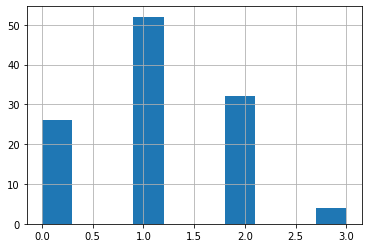

In [10]:
died_vent['qSOFA_score'].hist()

<AxesSubplot:>

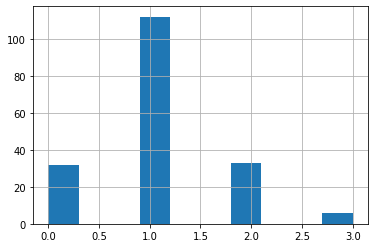

In [11]:
survived_vent['qSOFA_score'].hist()

In [12]:
Counter(died_vent['qSOFA_score'])

Counter({3.0: 4, 0.0: 26, 2.0: 32, 1.0: 52, nan: 1, nan: 1, nan: 1})

In [13]:
Counter(survived_vent['qSOFA_score'])

Counter({1.0: 112, 2.0: 33, 0.0: 32, 3.0: 6, nan: 1, nan: 1, nan: 1})

### Lottery 

In [14]:
lot_df = pd.read_csv('sim_results/lottery_1.0.csv', index_col=False)

In [15]:
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]

In [16]:
expired_df['allocated_vent']

32        yes
112       yes
120       yes
124       yes
181       yes
         ... 
651891    yes
651943    yes
651966    yes
651993    yes
651994    yes
Name: allocated_vent, Length: 16734, dtype: object

In [17]:
# percentage died
(len(expired_df) / len(lot_df) ) * 100

2.566564417177914

In [18]:
Counter(expired_df['qSOFA_score'])

Counter({2.0: 6310, 1.0: 7709, 3.0: 2429, 0.0: 286})

In [19]:
# to get means divide by iterations 
death_counts = Counter(expired_df['race_display'])
death_counts

Counter({'White': 4779,
         'Hispanic': 7903,
         'Other Race': 1275,
         'Black or African American': 1931,
         'Unknown': 743,
         'Decline to Specify': 97,
         'Asian': 6})

In [20]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
counts

Counter({'Hispanic': 3435,
         'White': 2587,
         'Black or African American': 852,
         'Other Race': 447,
         'Decline to Specify': 90,
         'Unknown': 298})

In [21]:
# Proportion of patients with score of 1
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Hispanic': 43.46450714918386,
 'White': 54.132663737183506,
 'Black or African American': 44.122216468151215,
 'Other Race': 35.05882352941177,
 'Decline to Specify': 92.78350515463917,
 'Unknown': 40.107671601615074}

In [22]:
# Proportion of patients with score of 2
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])


prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 33.31240845365139,
 'Hispanic': 45.931924585600406,
 'Other Race': 24.784313725490197,
 'Unknown': 26.917900403768506,
 'Black or African American': 29.621957534955985}

In [23]:
# Proportion of patients with score of 3
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])

prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 24.754013464526153,
 'Hispanic': 8.983930153106416,
 'Other Race': 39.05882352941176,
 'White': 10.65076375810839,
 'Unknown': 31.493943472409153}

<AxesSubplot:>

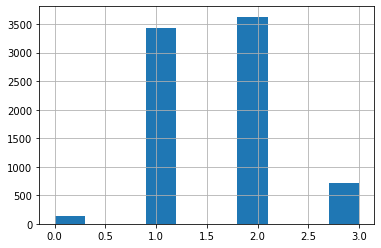

In [24]:
expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist()

<AxesSubplot:>

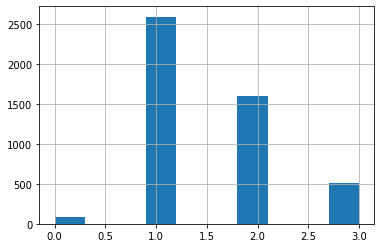

In [25]:
expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist()

<AxesSubplot:>

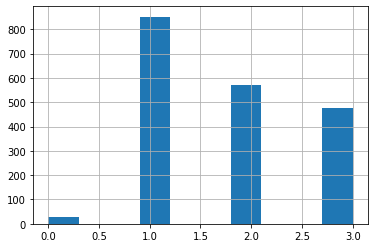

In [26]:
expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist()

### New York

In [27]:
lot_df = pd.read_csv('sim_results/new_york_1.0.csv', index_col=False)
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]
death_counts = Counter(expired_df['race_display'])
death_counts

Counter({'Black or African American': 1915,
         'Hispanic': 7930,
         'Other Race': 1217,
         'White': 4714,
         'Unknown': 789,
         'Decline to Specify': 101,
         'Asian': 5})

In [28]:
# percentage died 
(len(expired_df) / len(lot_df) ) * 100

2.5569018404907973

In [29]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 0.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 1.4099216710182767,
 'White': 2.248621128553246,
 'Hispanic': 2.257250945775536,
 'Other Race': 0.8216926869350863,
 'Unknown': 1.0139416983523446,
 'Asian': 100.0,
 'Decline to Specify': 1.9801980198019802}

In [30]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 41.14882506527415,
 'Hispanic': 41.70239596469105,
 'Other Race': 35.41495480690222,
 'White': 53.478998727195595,
 'Unknown': 40.937896070975924,
 'Decline to Specify': 98.01980198019803}

In [31]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 34.51421298260501,
 'Other Race': 23.8290879211175,
 'Hispanic': 47.07440100882724,
 'Unknown': 26.362484157160964,
 'Black or African American': 32.637075718015666}

In [32]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 9.75816716164616,
 'Black or African American': 24.804177545691903,
 'Hispanic': 8.96595208070618,
 'Unknown': 31.685678073510775,
 'Other Race': 39.93426458504519}

AxesSubplot(0.125,0.125;0.775x0.755)


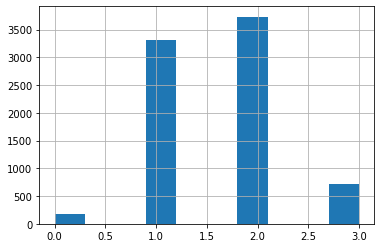

In [33]:
print(expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


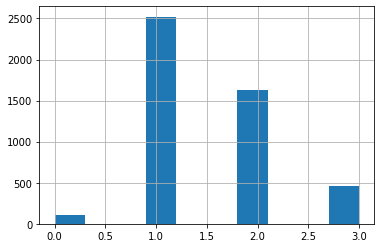

In [34]:
print(expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


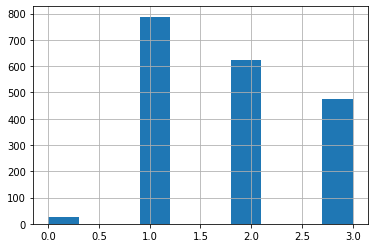

In [35]:
print(expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist())

### Maryland 

In [36]:
lot_df = pd.read_csv('sim_results/maryland_1.0.csv', index_col=False)
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]
death_counts = Counter(expired_df['race_display'])
death_counts

Counter({'Hispanic': 7913,
         'Unknown': 801,
         'White': 4693,
         'Other Race': 1243,
         'Black or African American': 1959,
         'Asian': 6,
         'Decline to Specify': 113})

In [37]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 0.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Asian': 100.0,
 'Hispanic': 2.0851762921774295,
 'White': 1.9390581717451523,
 'Unknown': 1.4981273408239701,
 'Black or African American': 0.7656967840735069,
 'Decline to Specify': 3.5398230088495577,
 'Other Race': 1.1263073209975865}

In [38]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Hispanic': 42.423859471755335,
 'Black or African American': 43.49157733537519,
 'White': 54.20839548263371,
 'Unknown': 37.95255930087391,
 'Other Race': 35.80048270313757,
 'Decline to Specify': 96.46017699115043}

In [39]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Unknown': 26.34207240948814,
 'Hispanic': 46.80904840136485,
 'White': 33.70978052418496,
 'Other Race': 23.49155269509252,
 'Black or African American': 29.402756508422666}

In [40]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 26.339969372128635,
 'White': 10.14276582143618,
 'Unknown': 34.20724094881398,
 'Other Race': 39.581657280772326,
 'Hispanic': 8.681915834702389}

AxesSubplot(0.125,0.125;0.775x0.755)


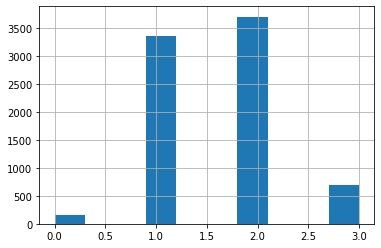

In [41]:
print(expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


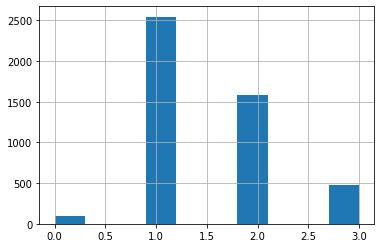

In [42]:
print(expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


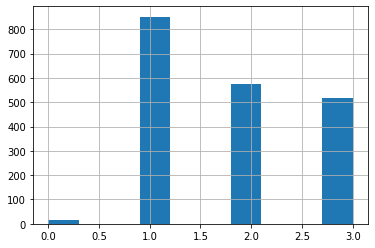

In [43]:
print(expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist())

### Youngest

In [44]:
lot_df = pd.read_csv('sim_results/youngest_1.0.csv', index_col=False)
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]
death_counts = Counter(expired_df['race_display'])
death_counts

Counter({'Unknown': 719,
         'Hispanic': 7852,
         'White': 4739,
         'Black or African American': 2026,
         'Other Race': 1201,
         'Decline to Specify': 108,
         'Asian': 4})

In [45]:
# percentage died 
(len(expired_df) / len(lot_df) ) * 100

2.553527607361963

In [46]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 0.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 1.519307870858831,
 'Other Race': 0.9991673605328892,
 'Hispanic': 1.9612837493632196,
 'Black or African American': 1.4313919052319843,
 'Decline to Specify': 10.185185185185185,
 'Unknown': 1.1126564673157162,
 'Asian': 100.0}

In [47]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Hispanic': 41.479877738155885,
 'White': 54.56847436167968,
 'Black or African American': 42.941757156959525,
 'Other Race': 33.22231473771857,
 'Unknown': 39.63838664812239,
 'Decline to Specify': 89.81481481481481}

In [48]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Unknown': 29.346314325452017,
 'Hispanic': 47.42740703005603,
 'Black or African American': 29.56564659427443,
 'White': 33.40367166068791,
 'Other Race': 24.812656119900083}

In [49]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 10.508546106773581,
 'Hispanic': 9.13143148242486,
 'Other Race': 40.96586178184846,
 'Black or African American': 26.061204343534055,
 'Unknown': 29.902642559109875}

AxesSubplot(0.125,0.125;0.775x0.755)


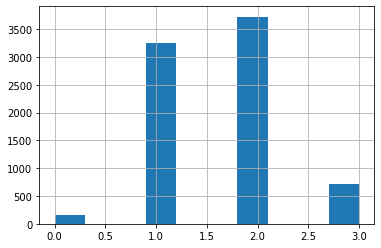

In [50]:
print(expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


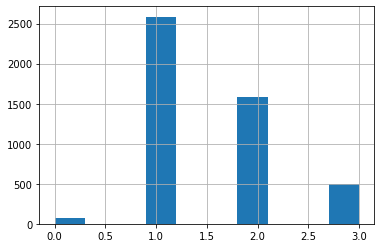

In [51]:
print(expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


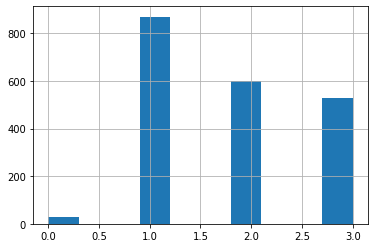

In [52]:
print(expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist())

### Sickest 

In [53]:
lot_df = pd.read_csv('sim_results/sickest_first_1.0.csv', index_col=False)
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]
death_counts = Counter(expired_df['race_display'])
death_counts

Counter({'Black or African American': 1912,
         'Hispanic': 7972,
         'Other Race': 1253,
         'Unknown': 757,
         'White': 4514,
         'Decline to Specify': 113,
         'Asian': 6})

In [54]:
# percentage died
(len(expired_df) / len(lot_df) ) * 100

2.5348159509202453

In [55]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 0.0]['race_display'])
prop_dict = {}


for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Hispanic': 1.9192172604114401,
 'Black or African American': 1.0983263598326358,
 'Unknown': 2.1136063408190227,
 'Decline to Specify': 7.079646017699115,
 'White': 1.6171909614532565,
 'Asian': 100.0,
 'Other Race': 0.8778930566640064}

In [56]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 45.92050209205021,
 'Hispanic': 43.08830908178625,
 'White': 53.278688524590166,
 'Other Race': 35.51476456504389,
 'Decline to Specify': 92.92035398230088,
 'Unknown': 41.21532364597093}

In [57]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Other Race': 24.421388667198723,
 'Hispanic': 46.2117410938284,
 'White': 34.337616304829425,
 'Unknown': 24.702774108322327,
 'Black or African American': 29.654811715481173}

In [58]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 23.326359832635983,
 'Hispanic': 8.780732563973908,
 'Other Race': 39.185953711093376,
 'Unknown': 31.968295904887718,
 'White': 10.766504209127161}

AxesSubplot(0.125,0.125;0.775x0.755)


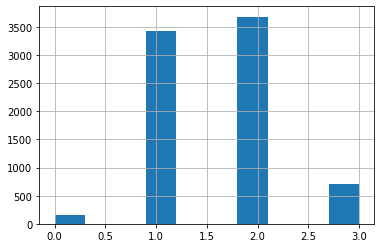

In [59]:
print(expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


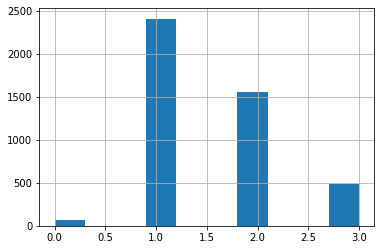

In [60]:
print(expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


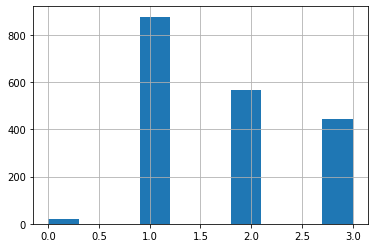

In [61]:
print(expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist())

### Max Life Years

In [62]:
lot_df = pd.read_csv('sim_results/max_life_years_1.0.csv', index_col=False)
expired_df = lot_df[lot_df['death'] == 1]
expired_df = expired_df[~expired_df['vent_hours_summed'].isnull()]
death_counts = Counter(expired_df['race_display'])
death_counts 

Counter({'Other Race': 1249,
         'White': 4682,
         'Hispanic': 7888,
         'Black or African American': 1946,
         'Decline to Specify': 110,
         'Unknown': 683,
         'Asian': 4})

In [63]:
# percentage died 
(len(expired_df) / len(lot_df) ) * 100

2.5401840490797545

In [64]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 0.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Other Race': 0.9607686148919135,
 'White': 2.1571977787270398,
 'Hispanic': 1.8509127789046655,
 'Black or African American': 1.1305241521068858,
 'Unknown': 2.049780380673499,
 'Decline to Specify': 2.727272727272727,
 'Asian': 100.0}

In [65]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 1.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Other Race': 36.74939951961569,
 'White': 53.353267834258865,
 'Hispanic': 41.64553752535497,
 'Black or African American': 42.54881808838643,
 'Decline to Specify': 97.27272727272728,
 'Unknown': 41.288433382137626}

In [66]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 2.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'White': 33.8316958564716,
 'Hispanic': 47.43914807302232,
 'Black or African American': 29.958890030832475,
 'Other Race': 24.579663730984787,
 'Unknown': 26.500732064421666}

In [67]:
counts = Counter(expired_df[expired_df['qSOFA_score'] == 3.0]['race_display'])
prop_dict = {}

for key in counts: 
    prop_dict[key] = (counts[key] / death_counts[key]) * 100 

prop_dict

{'Black or African American': 26.361767728674202,
 'White': 10.657838530542502,
 'Hispanic': 9.064401622718053,
 'Unknown': 30.161054172767205,
 'Other Race': 37.710168134507605}

AxesSubplot(0.125,0.125;0.775x0.755)


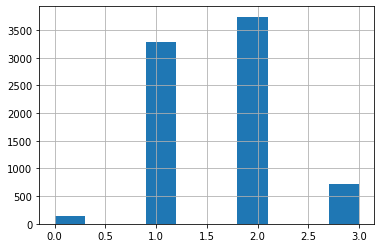

In [68]:
print(expired_df[expired_df['race_display'] == 'Hispanic']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


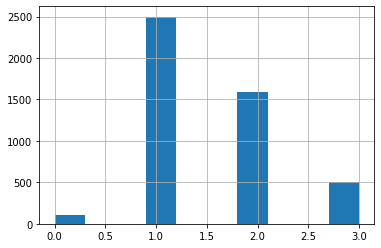

In [69]:
print(expired_df[expired_df['race_display'] == 'White']['qSOFA_score'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


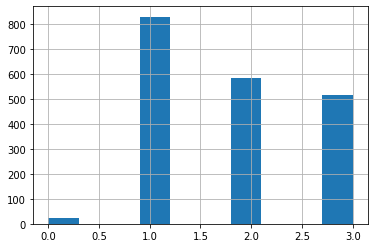

In [70]:
print(expired_df[expired_df['race_display'] == 'Black or African American']['qSOFA_score'].hist())

### qSOFA predictor on vent

In [71]:
qsofa_df = df[~df['qSOFA_score'].isnull()]

In [72]:
vent_func = lambda x: 0 if pd.isnull(x) else 1
qsofa_df['on_vent'] = qsofa_df.vent_hours_summed.apply(lambda row: vent_func(row))

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
qsofa_df['beg_date'] = pd.to_datetime(qsofa_df['admit_dt_tm'])
qsofa_df['end_date'] = pd.to_datetime(qsofa_df['discharge_dt_tm'])
qsofa_df['vent_start'] = pd.to_datetime(qsofa_df['vent_first_order_start_time'])
qsofa_df['vent_end'] = pd.to_datetime(qsofa_df['vent_last_order_end_time'])
qsofa_df['length_of_stay'] = (qsofa_df['end_date'] - qsofa_df['beg_date']).dt.days

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [74]:
qsofa_df['admit_time_to_vent'] = (qsofa_df['vent_start'] - qsofa_df['beg_date']).dt.days
qsofa_df['admit_time_to_vent_end'] = (qsofa_df['vent_end'] - qsofa_df['beg_date']).dt.days
qsofa_df['vent_duration'] = (qsofa_df['vent_end'] - qsofa_df['vent_start']).dt.days

/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/joel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [75]:
Counter(qsofa_df['on_vent'])

Counter({1: 297, 0: 1305})

In [76]:
icu_df = qsofa_df[~qsofa_df['icu_hours_summed'].isnull()]
icu_df

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,...,deid_mrn_encounter,deid_fin_encounter,on_vent,beg_date,end_date,vent_start,vent_end,admit_time_to_vent,admit_time_to_vent_end,vent_duration
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,...,84969,27818,1,2020-03-24 00:07:00,2020-03-26 18:30:00,2020-03-24 05:55:00,2020-03-26 16:22:00,0.0,2.0,2.0
6,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,...,80030,23744,1,2020-03-26 15:21:00,2020-04-08 13:15:00,2020-03-28 11:14:00,2020-04-03 14:31:00,1.0,7.0,6.0
11,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,...,84794,37705,1,2020-03-28 18:59:00,2020-06-01 15:15:00,2020-03-28 22:09:00,2020-05-27 04:53:00,0.0,59.0,59.0
17,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,...,84725,15345,1,2020-03-31 14:14:00,2020-04-17 17:20:00,2020-04-07 08:40:00,2020-04-17 15:56:00,6.0,17.0,10.0
18,2020-03-31 21:23:00,2020-04-08 14:40:00,Medical Center,IP Private/Semi Private room,40,Female,78704,Unknown,White,White Unknown Ethnicity,...,74571,18447,0,2020-03-31 21:23:00,2020-04-08 14:40:00,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,2020-11-15 18:38:00,2020-11-18 15:09:00,Williamson,IP Private/Semi Private room,74,Female,78664,Not Hispanic or Latino,White,White Non Hispanic,...,80870,31833,0,2020-11-15 18:38:00,2020-11-18 15:09:00,NaT,NaT,NaN,NaN,NaN
2433,2020-11-15 18:49:00,NaN,Hays,IP Private/Semi Private room,55,Female,78644,Hispanic or Latino,White,White Hispanic,...,62391,16897,0,2020-11-15 18:49:00,NaT,NaT,NaT,NaN,NaN,NaN
2437,2020-11-16 10:04:00,2020-11-18 18:10:00,Hays,IP Private/Semi Private room,70,Male,78610,Hispanic or Latino,White,White Hispanic,...,61246,41967,0,2020-11-16 10:04:00,2020-11-18 18:10:00,NaT,NaT,NaN,NaN,NaN
2450,2020-11-18 17:25:00,2020-11-19 18:10:00,Williamson,IP ICU,66,Male,78665,Unknown,White,White Unknown Ethnicity,...,67825,30836,0,2020-11-18 17:25:00,2020-11-19 18:10:00,NaT,NaT,NaN,NaN,NaN


In [77]:
testing_df = icu_df[['on_vent', 'qSOFA_score', 'length_of_stay', 'admit_time_to_vent', 'admit_time_to_vent_end', 'vent_duration']]

In [78]:
#Creatinine	Abs_Lymph	ALT	AST	Bili_Total	D-Dimer	Diastolic_Blood_Pressure	Dosing_Weight_(kg)	FiO2/Percent	Glasgow_Coma_Score	Lymph_Auto	Oxygen_Delivery_Method	Oxygen_Saturation	Platelet	pO2_Art	Procalcitonin	Respiratory_Rate	Systolic_Blood_Pressure	Troponin-I	WBC	Oxygen_Flow_Rate	Patient_Smoking_Status
icu_df.columns

Index(['admit_dt_tm', 'discharge_dt_tm', 'facility', 'encounter_type_display',
       'age_at_admit', 'gender', 'zip_cust_table', 'ethnicity_display',
       'race_display', 'race_eth_comb', 'length_of_stay', 'icd_prim',
       'deceased_dt_tm', 'discharge_disposition_display', 'dc_dispo_cat',
       'insured_uninsured', 'admit_source', 'arrival_mode',
       'vent_hours_summed', 'vent_first_order_start_time',
       'vent_last_order_end_time', 'icu_hours_summed', 'icu_first_begin_time',
       'icu_last_end_time', 'occupation', 'occ_cat', 'emp_yn', 'Creatinine',
       'Abs_Lymph', 'ALT', 'AST', 'Bili_Total', 'D-Dimer',
       'Diastolic_Blood_Pressure', 'Dosing_Weight_(kg)', 'FiO2/Percent',
       'Glasgow_Coma_Score', 'Lymph_Auto', 'Oxygen_Delivery_Method',
       'Oxygen_Saturation', 'Platelet', 'pO2_Art', 'Procalcitonin',
       'Respiratory_Rate', 'Systolic_Blood_Pressure', 'Troponin-I', 'WBC',
       'Oxygen_Flow_Rate', 'Patient_Smoking_Status', 'Visit_Reason',
       'Height_(i

In [79]:
vitals_vent_df = icu_df[['Creatinine',
       'Abs_Lymph', 'ALT', 'AST', 'Bili_Total', 'D-Dimer',
       'Diastolic_Blood_Pressure', 'Dosing_Weight_(kg)', 'FiO2/Percent',
       'Glasgow_Coma_Score', 'Lymph_Auto',
       'Oxygen_Saturation', 'Platelet', 'pO2_Art', 'Procalcitonin',
       'Respiratory_Rate', 'Systolic_Blood_Pressure', 'Troponin-I', 'WBC',
       'Oxygen_Flow_Rate','Mean_Arterial_Pressure', 'heart_pulse_comb', 'temp_oral_degC', 'calc_pulled_BMI', 'qSOFA_score', 'on_vent']]

In [80]:

vitals_length_stay_df = icu_df[['Creatinine',
       'Abs_Lymph', 'ALT', 'AST', 'Bili_Total', 'D-Dimer',
       'Diastolic_Blood_Pressure', 'Dosing_Weight_(kg)', 'FiO2/Percent',
       'Glasgow_Coma_Score', 'Lymph_Auto',
       'Oxygen_Saturation', 'Platelet', 'pO2_Art', 'Procalcitonin',
       'Respiratory_Rate', 'Systolic_Blood_Pressure', 'Troponin-I', 'WBC',
       'Oxygen_Flow_Rate','Mean_Arterial_Pressure', 'heart_pulse_comb', 'temp_oral_degC', 'calc_pulled_BMI', 'qSOFA_score', 'length_of_stay']]

In [81]:
vitals_vent_df

,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,...,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Mean_Arterial_Pressure,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,qSOFA_score,on_vent
1,2.9,2.00,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,...,36.0,0.73,35.1,NaN,NaN,97.0,NaN,30.620000,3.0,1
6,0.9,0.80,43,48.0,0.5,599,79.0,123.200,100.0,15.0,...,115.0,0.02,12.1,4.0,91.0,99.0,37.4,44.890000,1.0,1
11,1.5,4.20,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,...,102.0,0.07,19.4,50.0,NaN,143.0,37.1,34.540000,2.0,1
17,1.2,1.00,20,36.0,0.6,224,76.0,90.718,100.0,15.0,...,122.0,NaN,4.6,2.0,91.3,80.0,38.9,27.893795,0.0,1
18,0.7,NaN,44,45.0,0.3,264,82.0,136.078,45.0,15.0,...,133.0,<0.01,2.8,2.0,99.0,104.0,37.6,54.350000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,1.1,0.87,24,39.0,0.5,1465,80.0,99.790,NaN,15.0,...,172.0,0.01,6.9,4.0,110.7,86.0,37.2,35.890000,0.0,0
2433,1.0,2.19,51,35.0,0.4,3338,87.0,91.000,NaN,15.0,...,154.0,<0.01,8.1,6.0,109.3,65.0,37.1,31.421189,0.0,0
2437,1.2,1.07,34,19.0,1.1,NaN,76.0,113.398,93.0,15.0,...,176.0,0.02,11.6,NaN,109.3,79.0,36.7,36.917990,0.0,0
2450,0.9,2.83,18,25.0,0.4,NaN,82.0,101.605,NaN,15.0,...,161.0,0.01,10.2,NaN,108.3,76.0,36.7,32.390000,0.0,0


In [82]:
non_empty = vitals_vent_df.dropna()
non_empty_length = vitals_length_stay_df.dropna()

In [83]:
testing_df.corr()

,on_vent,qSOFA_score,length_of_stay,admit_time_to_vent,admit_time_to_vent_end,vent_duration
on_vent,1.000000,0.226020,0.478201,NaN,NaN,NaN
qSOFA_score,0.226020,1.000000,0.077169,-0.293053,-0.068538,0.012558
length_of_stay,0.478201,0.077169,1.000000,0.246015,0.924668,0.903446
admit_time_to_vent,NaN,-0.293053,0.246015,1.000000,0.302299,0.043700
admit_time_to_vent_end,NaN,-0.068538,0.924668,0.302299,1.000000,0.965177
vent_duration,NaN,0.012558,0.903446,0.043700,0.965177,1.000000


In [84]:
vent_testing_df = testing_df[testing_df['on_vent'] == 1]
#filter_df[filter_df['admit_time_to_vent'] <= timedelta(0)][['admit_dt_tm', 'vent_first_order_start_time']]
#vent_testing_df[['length_of_stay', 'admit_time_to_vent', 'admit_time_to_vent_end', 'vent_duration']] = vent_testing_df[['length_of_stay', 'admit_time_to_vent', 'admit_time_to_vent_end', 'vent_duration']].astype(int)

In [85]:
vent_testing_df.corr()

,on_vent,qSOFA_score,length_of_stay,admit_time_to_vent,admit_time_to_vent_end,vent_duration
on_vent,NaN,NaN,NaN,NaN,NaN,NaN
qSOFA_score,NaN,1.000000,-0.067797,-0.293053,-0.068538,0.012558
length_of_stay,NaN,-0.067797,1.000000,0.246015,0.924668,0.903446
admit_time_to_vent,NaN,-0.293053,0.246015,1.000000,0.302299,0.043700
admit_time_to_vent_end,NaN,-0.068538,0.924668,0.302299,1.000000,0.965177
vent_duration,NaN,0.012558,0.903446,0.043700,0.965177,1.000000


/home/joel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='qSOFA_score', ylabel='length_of_stay'>

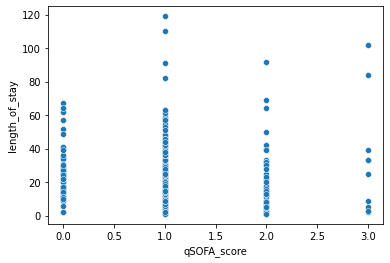

In [86]:
sn.scatterplot(vent_testing_df['qSOFA_score'], vent_testing_df['length_of_stay'] )

/home/joel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='qSOFA_score', ylabel='admit_time_to_vent'>

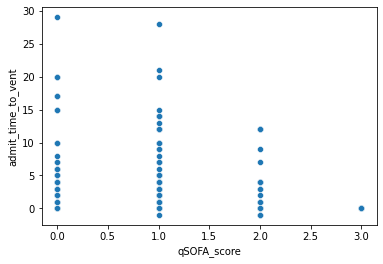

In [87]:
sn.scatterplot(vent_testing_df['qSOFA_score'], vent_testing_df['admit_time_to_vent'] )

/home/joel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='qSOFA_score', ylabel='admit_time_to_vent_end'>

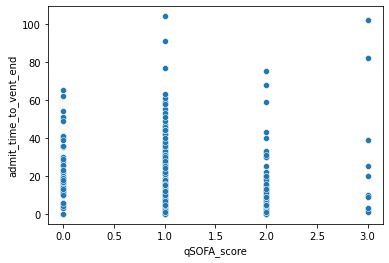

In [88]:
sn.scatterplot(vent_testing_df['qSOFA_score'], vent_testing_df['admit_time_to_vent_end'] )

/home/joel/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='qSOFA_score', ylabel='vent_duration'>

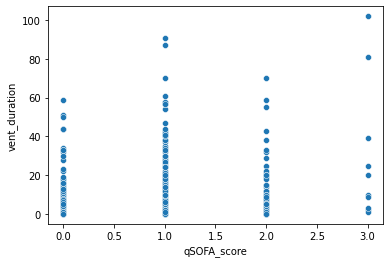

In [89]:
sn.scatterplot(vent_testing_df['qSOFA_score'], vent_testing_df['vent_duration'] )

In [90]:
# logistiic regression model for qSOFA on vent
model = stats.Logit(icu_df['on_vent'], icu_df['qSOFA_score'])
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.693022
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                on_vent   No. Observations:                  716
Model:                          Logit   Df Residuals:                      715
Method:                           MLE   Df Model:                            0
Date:                Mon, 26 Apr 2021   Pseudo R-squ.:                -0.02753
Time:                        17:08:09   Log-Likelihood:                -496.20
converged:                       True   LL-Null:                       -482.91
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
qSOFA_score    -0.0275      0.065     -0.423      0.672      -0.155       0.100
===============================================================================
"""

In [91]:
# auc score 
roc_auc_score(icu_df['on_vent'], res.predict(icu_df['qSOFA_score']))

0.3832767436772202

In [92]:
temp_df = icu_df[['length_of_stay', 'qSOFA_score']].dropna()

In [93]:
# linear regression model for qSOFA and length of stay
model = stats.OLS(temp_df['length_of_stay'], temp_df['qSOFA_score'])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         length_of_stay   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.336
Method:                 Least Squares   F-statistic:                              345.1
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    1.28e-62
Time:                        17:08:09   Log-Likelihood:                         -2930.5
No. Observations:                 681   AIC:                                      5863.
Df Residuals:                     680   BIC:                                      5868.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
qSOFA_score    11.1002      0.597     18.578      0.000       9.927      12.273
==============================================================================
Omnibus:                      225.571   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              840.156
Skew:                           1.525   Prob(JB):                    3.65e-183
Kurtosis:                       7.507   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
# logistiic regression model for qSOFA and vitals on vent
X = non_empty[['Creatinine',
       'Abs_Lymph', 'AST',
       'Diastolic_Blood_Pressure', 'Dosing_Weight_(kg)', 'FiO2/Percent',
       'Glasgow_Coma_Score', 'Lymph_Auto',
       'Oxygen_Saturation', 'Platelet', 'pO2_Art',
       'Respiratory_Rate', 'Systolic_Blood_Pressure', 'WBC',
       'Oxygen_Flow_Rate','Mean_Arterial_Pressure', 'heart_pulse_comb', 'temp_oral_degC', 'calc_pulled_BMI', 'qSOFA_score']]

y = non_empty['on_vent']

X2 = non_empty_length[['Creatinine',
       'Abs_Lymph', 'AST',
       'Diastolic_Blood_Pressure', 'Dosing_Weight_(kg)', 'FiO2/Percent',
       'Glasgow_Coma_Score', 'Lymph_Auto',
       'Oxygen_Saturation', 'Platelet', 'pO2_Art',
       'Respiratory_Rate', 'Systolic_Blood_Pressure', 'WBC',
       'Oxygen_Flow_Rate','Mean_Arterial_Pressure', 'heart_pulse_comb', 'temp_oral_degC', 'calc_pulled_BMI', 'qSOFA_score']]

y2 = non_empty_length['length_of_stay']


In [95]:


model = stats.Logit(y, X)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.464392
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                on_vent   No. Observations:                  143
Model:                          Logit   Df Residuals:                      123
Method:                           MLE   Df Model:                           19
Date:                Mon, 26 Apr 2021   Pseudo R-squ.:                  0.1770
Time:                        17:08:09   Log-Likelihood:                -66.408
converged:                       True   LL-Null:                       -80.687
Covariance Type:            nonrobust   LLR p-value:                   0.07325
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Creatinine                   0.2578      0.211      1.221      0.222      -0.156       0.672
Abs_Lymph                   -0.7744      0.699     -1.108      0.268      -2.144       0.595
AST                          0.0013      0.004      0.346      0.730      -0.006       0.009
Diastolic_Blood_Pressure    -0.0407      0.031     -1.296      0.195      -0.102       0.021
Dosing_Weight_(kg)           0.0263      0.015      1.703      0.089      -0.004       0.057
FiO2/Percent                 0.0094      0.012      0.816      0.414      -0.013       0.032
Glasgow_Coma_Score          -0.1399      0.184     -0.759      0.448      -0.501       0.221
Lymph_Auto                   0.0199      0.063      0.317      0.751      -0.103       0.143
Oxygen_Saturation           -0.0314      0.028     -1.109      0.267      -0.087       0.024
Platelet                    -0.0005      0.003     -0.160      0.873      -0.006       0.005
pO2_Art                      0.0038      0.004      0.861      0.389      -0.005       0.013
Respiratory_Rate             0.0233      0.044      0.533      0.594      -0.062       0.109
Systolic_Blood_Pressure     -0.0056      0.017     -0.320      0.749      -0.040       0.029
WBC                          0.1383      0.103      1.337      0.181      -0.064       0.341
Oxygen_Flow_Rate            -0.0035      0.018     -0.189      0.850      -0.040       0.033
Mean_Arterial_Pressure       0.0496      0.038      1.293      0.196      -0.026       0.125
heart_pulse_comb             0.0199      0.014      1.423      0.155      -0.008       0.047
temp_oral_degC              -0.0146      0.129     -0.113      0.910      -0.267       0.238
calc_pulled_BMI             -0.0444      0.040     -1.115      0.265      -0.122       0.034
qSOFA_score                  0.3848      0.486      0.791      0.429      -0.569       1.338
============================================================================================
"""

In [96]:
# auc score 
roc_auc_score(non_empty['on_vent'], res.predict(X))

0.7847871235721704

In [97]:
model = stats.OLS(y2, X2)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         length_of_stay   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              15.97
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    5.20e-25
Time:                        17:08:09   Log-Likelihood:                         -582.94
No. Observations:                 140   AIC:                                      1206.
Df Residuals:                     120   BIC:                                      1265.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Creatinine                  -0.6180      1.066     -0.580      0.563      -2.729       1.493
Abs_Lymph                   -4.7119      4.298     -1.096      0.275     -13.222       3.798
AST                         -0.0488      0.024     -2.012      0.046      -0.097      -0.001
Diastolic_Blood_Pressure    -0.3492      0.227     -1.537      0.127      -0.799       0.101
Dosing_Weight_(kg)          -0.0922      0.098     -0.938      0.350      -0.287       0.102
FiO2/Percent                 0.0026      0.074      0.035      0.972      -0.143       0.149
Glasgow_Coma_Score           0.5897      0.694      0.850      0.397      -0.784       1.964
Lymph_Auto                   0.2861      0.413      0.692      0.490      -0.533       1.105
Oxygen_Saturation           -0.1435      0.145     -0.987      0.325      -0.431       0.144
Platelet                     0.0132      0.018      0.747      0.456      -0.022       0.048
pO2_Art                     -0.0206      0.029     -0.709      0.480      -0.078       0.037
Respiratory_Rate             0.1116      0.236      0.473      0.637      -0.355       0.578
Systolic_Blood_Pressure     -0.0428      0.121     -0.355      0.723      -0.281       0.196
WBC                          0.2919      0.524      0.557      0.579      -0.746       1.330
Oxygen_Flow_Rate            -0.0385      0.106     -0.364      0.717      -0.248       0.171
Mean_Arterial_Pressure       0.1602      0.289      0.554      0.580      -0.412       0.732
heart_pulse_comb             0.0868      0.089      0.971      0.334      -0.090       0.264
temp_oral_degC               1.0453      0.675      1.549      0.124      -0.290       2.381
calc_pulled_BMI              0.1394      0.279      0.500      0.618      -0.412       0.691
qSOFA_score                  1.8064      3.104      0.582      0.562      -4.339       7.952
==============================================================================
Omnibus:                       26.408   Durbin-Watson:                   2.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.483
Skew:                           1.054   Prob(JB):                     1.97e-08
Kurtosis:                       4.280   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""